In [170]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv1D 
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import MaxPooling1D

In [171]:
df=pd.read_csv(r"C:\Users\Vandana\Documents\Local_github\Energy-Usage-Prediction-Project\Code\demand_weather_date_daily.csv")
df.head()

,Date,Operational Demand (MW),Transpiration,Rain,Evaporation,Max Temp,Min Temp,Max Hum,Min Hum,Av Wind,Solar Rad,Year,month,Day_of_week,Day_of_month,Day_of_year,week_of_year,state_holiday,mnth_sin,mnth_cos
0,2009-01-01,95141.184,11.2,0.0,11.6,37.2,18.8,65,20,6.1,34.01,2009,1,3,1,1,1,True,0.0,1.0
1,2009-01-02,108058.504,10.2,0.0,12.8,36.1,21.9,70,25,5.31,34.25,2009,1,4,2,2,1,False,0.0,1.0
2,2009-01-03,95788.860,9.4,0.0,11.8,34.4,20.3,79,29,5.45,34.11,2009,1,5,3,3,1,False,0.0,1.0
3,2009-01-04,93777.404,10.5,0.0,11.2,36.5,18.5,62,20,5.25,34.05,2009,1,6,4,4,1,False,0.0,1.0
4,2009-01-05,112678.424,11.9,0.0,11.4,37.2,21.8,63,17,6.77,34.18,2009,1,0,5,5,2,False,0.0,1.0


In [172]:
df.drop(df.tail(1).index,inplace=True) # drop last 1 rows
df.drop(df.columns[[0]], axis=1, inplace=True)
df.corr()

,Operational Demand (MW),Year,month,Day_of_week,Day_of_month,Day_of_year,week_of_year,state_holiday,mnth_sin,mnth_cos
Operational Demand (MW),1.000000,0.046362,-0.303182,-0.299198,-0.001956,-0.301117,-0.301334,-0.078910,0.170344,0.143464
Year,0.046362,1.000000,-0.051701,0.000247,-0.005458,-0.051735,-0.052550,0.002599,0.052026,-0.006554
month,-0.303182,-0.051701,1.000000,-0.002476,0.007127,0.996465,0.969366,-0.044325,-0.757777,-0.219472
Day_of_week,-0.299198,0.000247,-0.002476,1.000000,0.000118,-0.002454,-0.001881,-0.115854,-0.000098,-0.000741
Day_of_month,-0.001956,-0.005458,0.007127,0.000118,1.000000,0.090808,0.063445,0.025573,-0.004250,-0.008342
Day_of_year,-0.301117,-0.051735,0.996465,-0.002454,0.090808,1.000000,0.970783,-0.041970,-0.757670,-0.215939
week_of_year,-0.301334,-0.052550,0.969366,-0.001881,0.063445,0.970783,1.000000,-0.012462,-0.753304,-0.208390
state_holiday,-0.078910,0.002599,-0.044325,-0.115854,0.025573,-0.041970,-0.012462,1.000000,0.053088,0.095198
mnth_sin,0.170344,0.052026,-0.757777,-0.000098,-0.004250,-0.757670,-0.753304,0.053088,1.000000,-0.000758
mnth_cos,0.143464,-0.006554,-0.219472,-0.000741,-0.008342,-0.215939,-0.208390,0.095198,-0.000758,1.000000


# Univariate CNN Models

In [173]:
uni_df=df["Operational Demand (MW)"]

In [177]:
#len(uni_df)*.8

In [178]:
train_idx=int(len(uni_df)*.8)
train_idx

3975

In [179]:
# multi-step data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(0,len(sequence),6):
    # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
train = list(uni_df[:train_idx])
test=list(uni_df[train_idx:])
# choose a number of time steps
n_steps_in, n_steps_out = 12, 6
# split into samples
X, y = split_sequence(train, n_steps_in, n_steps_out)
# summarize the data
print(X[0], y[0])
print(X[1], y[1])

[ 95141.184 108058.504  95788.86   93777.404 112678.424 111824.976
 110104.118 114229.828 113488.238 103767.418 103885.72  100542.602] [ 92333.888  95147.1   113699.454 126200.296  97772.34   88782.604]
[110104.118 114229.828 113488.238 103767.418 103885.72  100542.602
  92333.888  95147.1   113699.454 126200.296  97772.34   88782.604] [96426.502 95562.286 95787.974 98330.458 99124.008 89807.866]


In [180]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [181]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [182]:
# fit model
model.fit(X, y, epochs=100)

Epoch 1/100
21/21 [==============================] - 1s 4ms/step - loss: 5955436032.0000
Epoch 2/100
21/21 [==============================] - 0s 4ms/step - loss: 1670386560.0000
Epoch 3/100
21/21 [==============================] - 0s 4ms/step - loss: 201848864.0000
Epoch 4/100
21/21 [==============================] - 0s 4ms/step - loss: 93734936.0000
Epoch 5/100
21/21 [==============================] - 0s 4ms/step - loss: 87743160.0000
Epoch 6/100
21/21 [==============================] - 0s 4ms/step - loss: 86642064.0000
Epoch 7/100
21/21 [==============================] - 0s 5ms/step - loss: 86134576.0000
Epoch 8/100
21/21 [==============================] - 0s 5ms/step - loss: 87237976.0000
Epoch 9/100
21/21 [==============================] - 0s 4ms/step - loss: 86271624.0000
Epoch 10/100
21/21 [==============================] - 0s 4ms/step - loss: 86426568.0000
Epoch 11/100
21/21 [==============================] - 0s 4ms/step - loss: 85772576.0000
Epoch 12/100
21/21 [================

21/21 [==============================] - 0s 4ms/step - loss: 73899184.0000
Epoch 95/100
21/21 [==============================] - 0s 4ms/step - loss: 75670488.0000
Epoch 96/100
21/21 [==============================] - 0s 5ms/step - loss: 74390648.0000
Epoch 97/100
21/21 [==============================] - 0s 4ms/step - loss: 73513304.0000
Epoch 98/100
21/21 [==============================] - 0s 4ms/step - loss: 73369112.0000
Epoch 99/100
21/21 [==============================] - 0s 4ms/step - loss: 72933888.0000
Epoch 100/100
21/21 [==============================] - 0s 4ms/step - loss: 78300160.0000


In [183]:
# Predictions-
X_test, y_test = split_sequence(test, n_steps_in, n_steps_out)

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
yhat = model.predict(X_test, verbose=0)
print(yhat)

[[ 97642.07   97075.336  99327.766 102739.5   102842.85  102981.27 ]
 [113469.58  106930.92   98951.984 102294.8   112114.16  113576.16 ]
 [116069.75  118356.25  108419.66  107130.26  108210.77  111119.42 ]
 [108429.31  112813.8   110554.19  104502.95  102756.28  107711.93 ]
 [ 89625.75   96817.97   94325.64   90414.44   84796.45   88007.19 ]
 [ 79176.64   85697.695  86300.6    84594.22   80449.62   80575.35 ]
 [ 85593.336  93409.13   88866.445  86084.84   87409.055  84643.234]
 [ 99834.516 102221.93  102231.664 100885.34   99696.86  100950.79 ]
 [ 97876.06   99132.484  99378.08  101302.836 100644.65  100744.8  ]
 [102850.836 100240.93   92223.266  92281.46  100172.445 101161.86 ]
 [110905.41  106520.28   98693.32   91029.875  96934.38  106543.695]
 [103206.64  116425.305 110434.89  103573.49   93507.18   98167.5  ]
 [107157.07  115894.016 114195.766 109998.63  108696.88  107873.88 ]
 [105890.8   111890.76  113506.05  113609.27  111959.35  112651.52 ]
 [107826.55  111008.34  108421.055

In [184]:
len(y_test),len(yhat)

(163, 163)

In [185]:
import itertools
new_yhat=list(itertools.chain.from_iterable(yhat))
new_yhat

[97642.07,
 97075.336,
 99327.766,
 102739.5,
 102842.85,
 102981.27,
 113469.58,
 106930.92,
 98951.984,
 102294.8,
 112114.16,
 113576.16,
 116069.75,
 118356.25,
 108419.66,
 107130.26,
 108210.77,
 111119.42,
 108429.31,
 112813.8,
 110554.19,
 104502.95,
 102756.28,
 107711.93,
 89625.75,
 96817.97,
 94325.64,
 90414.44,
 84796.45,
 88007.19,
 79176.64,
 85697.695,
 86300.6,
 84594.22,
 80449.62,
 80575.35,
 85593.336,
 93409.13,
 88866.445,
 86084.84,
 87409.055,
 84643.234,
 99834.516,
 102221.93,
 102231.664,
 100885.34,
 99696.86,
 100950.79,
 97876.06,
 99132.484,
 99378.08,
 101302.836,
 100644.65,
 100744.8,
 102850.836,
 100240.93,
 92223.266,
 92281.46,
 100172.445,
 101161.86,
 110905.41,
 106520.28,
 98693.32,
 91029.875,
 96934.38,
 106543.695,
 103206.64,
 116425.305,
 110434.89,
 103573.49,
 93507.18,
 98167.5,
 107157.07,
 115894.016,
 114195.766,
 109998.63,
 108696.88,
 107873.88,
 105890.8,
 111890.76,
 113506.05,
 113609.27,
 111959.35,
 112651.52,
 107826.55,
 

In [186]:
new_ytest=list(itertools.chain.from_iterable(y_test))
new_ytest

[93816.27,
 81976.694,
 93882.954,
 103905.37,
 119881.97,
 127712.866,
 133655.944,
 124529.572,
 121664.988,
 127133.564,
 123499.224,
 118094.752,
 101590.586,
 93130.782,
 92536.854,
 90708.86,
 101072.486,
 103411.496,
 100796.24,
 95092.166,
 90224.798,
 83877.41,
 84045.358,
 83073.062,
 84780.664,
 83634.02,
 87094.384,
 80359.962,
 75312.45,
 85442.82,
 101074.798,
 100145.522,
 97614.578,
 90730.336,
 94997.642,
 97647.364,
 98504.904,
 106750.326,
 115289.618,
 118151.654,
 120331.304,
 113889.496,
 95106.188,
 87312.884,
 98632.388,
 94403.732,
 91694.5,
 94261.278,
 100257.4,
 96679.044,
 102163.238,
 118760.848,
 122531.582,
 104194.146,
 92330.236,
 87732.036,
 82740.7,
 93801.98,
 119212.694,
 137117.75,
 132879.676,
 118597.656,
 110685.468,
 97035.692,
 82882.152,
 98085.172,
 111081.888,
 111902.25,
 122877.752,
 132391.97,
 105510.318,
 87668.832,
 101385.682,
 108244.712,
 124550.84,
 129373.51,
 120761.796,
 108171.112,
 108883.9,
 116216.434,
 118339.492,
 110149

In [187]:
len(new_ytest),len(new_yhat)

(978, 978)

In [188]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(new_ytest,new_yhat)

8.426987789336291

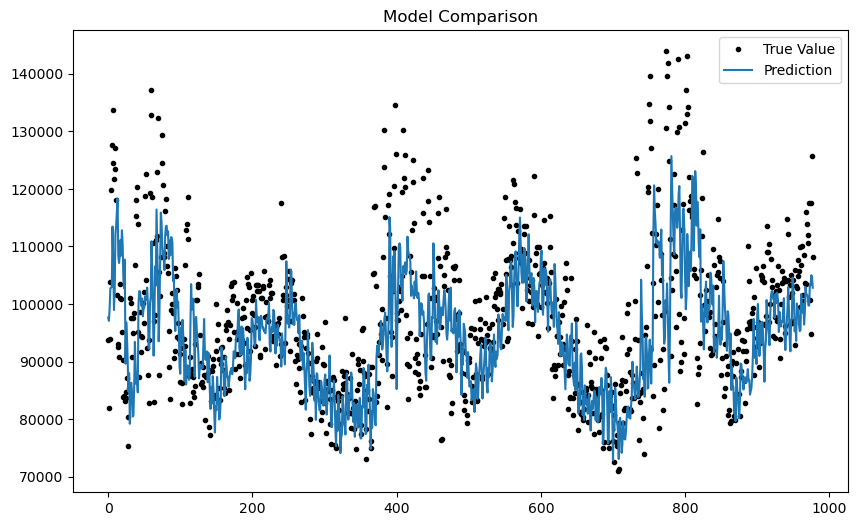

In [189]:
def comparison_plot():
    """Visualizing the training + validation sets"""
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.set_title("Model Comparison")
    ax.plot(new_ytest,'.k', label='True Value')
    ax.plot(new_yhat, label="Prediction")
    ax.legend()
    plt.show()   
comparison_plot()

In [190]:
# Forecasting

def split_seq_forecast(sequence, n_steps):
    X = list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + n_steps
    # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
    # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)        
    return array(X)

X_forecast= split_seq_forecast(uni_df[-13:],12)
# summarize the data
print(X_forecast)

[[113899.372 112022.71  110569.728 117611.318 100753.36   94759.052
  117483.444 125742.844 108141.834 104880.794 100860.726 112085.704]]


In [191]:
X_forecast = X_forecast.reshape((X_forecast.shape[0], X_forecast.shape[1], n_features))
y_forecast = model.predict(X_forecast, verbose=0)
print(y_forecast)

[[ 98027.57 112634.08 113852.57 109830.75 101647.13 102614.05]]


# 2 days (48 observation) Prediction

In [192]:
df=pd.read_csv(r"C:\Users\Vandana\Documents\Local_github\Energy-Usage-Prediction-Project\Code\merged_data.csv")
df.head()

,Unnamed: 0,timestamp,Operational Demand (MW),temperature(celcius),dew_point(celcius),humidity(%),Wind,wind_speed(mph),wind_gush(mph),pressure(in),precip.(in),Condition
0,0,2017-01-22 00:00:00,1815.214,20.0,15.0,73.0,SSW,9.0,0.0,29.0,0.0,Fair
1,1,2017-01-22 00:30:00,1777.040,20.0,15.0,73.0,SSW,10.0,0.0,29.0,0.0,Fair
2,2,2017-01-22 01:00:00,1745.448,18.9,15.0,78.0,SSW,9.0,0.0,29.0,0.0,Fair
3,3,2017-01-22 01:30:00,1729.164,18.9,15.0,78.0,SSW,15.0,0.0,29.0,0.0,Fair
4,4,2017-01-22 02:00:00,1714.276,18.9,12.8,68.0,SSW,18.0,0.0,29.0,0.0,Fair


In [193]:
df.drop(df.columns[[0]], axis=1, inplace=True)
df.drop(df.tail(16).index,inplace=True) # drop last 1 rows

In [194]:
uni_df=df["Operational Demand (MW)"]
uni_df

0        1815.214
1        1777.040
2        1745.448
3        1729.164
4        1714.276
           ...   
97483    2321.674
97484    2226.440
97485    2115.170
97486    2022.864
97487    1940.888
Name: Operational Demand (MW), Length: 97488, dtype: float64

## with 96 obs input and 48 output

In [195]:
train_idx=int((len(uni_df)*.8//96)*96)
test_idx= len(uni_df)-96-48

In [196]:
# multi-step data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(0,len(sequence),48):
    # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
train = list(uni_df[:train_idx])
test=list(uni_df[train_idx:test_idx])
forecast=list(uni_df[test_idx:test_idx+97])
# choose a number of time steps
n_steps_in, n_steps_out = 96, 48
# split into samples
X, y = split_sequence(train, n_steps_in, n_steps_out)
# summarize the data
print(X[0], y[0])
print(X[1], y[1])

[1815.214 1777.04  1745.448 1729.164 1714.276 1699.92  1692.876 1676.196
 1683.966 1685.85  1690.912 1659.93  1667.302 1652.892 1642.998 1638.536
 1659.798 1670.03  1674.754 1669.434 1664.774 1655.122 1660.776 1661.4
 1663.378 1681.738 1675.242 1677.668 1683.986 1710.012 1748.488 1807.23
 1880.456 1959.534 2015.354 2073.35  2123.814 2139.672 2142.986 2167.454
 2140.688 2086.89  2033.71  1985.722 1935.62  1880.614 1829.74  1784.216
 1758.162 1732.998 1703.934 1693.164 1700.146 1697.204 1690.518 1686.722
 1689.496 1713.978 1754.14  1746.78  1824.148 1875.26  1932.81  1964.026
 1974.976 1991.562 1991.828 1987.052 1970.786 1954.778 1910.868 1882.934
 1866.642 1867.546 1871.102 1879.716 1915.602 1937.376 1960.388 2007.684
 2056.178 2084.572 2135.146 2164.166 2186.528 2210.686 2216.242 2254.24
 2230.83  2182.878 2132.912 2040.3   1997.99  1941.724 1876.622 1827.672] [1781.788 1760.222 1731.392 1704.372 1680.472 1650.382 1665.488 1646.602
 1646.506 1649.636 1694.902 1731.724 1822.318 1882.154

In [197]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [198]:
X.shape

(1622, 96, 1)

In [199]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [200]:
# fit model
model.fit(X, y, epochs=100)

Epoch 1/100
51/51 [==============================] - 1s 8ms/step - loss: 1524338.7500
Epoch 2/100
51/51 [==============================] - 0s 7ms/step - loss: 101458.3984
Epoch 3/100
51/51 [==============================] - 0s 8ms/step - loss: 52587.6406
Epoch 4/100
51/51 [==============================] - 0s 8ms/step - loss: 48432.4922
Epoch 5/100
51/51 [==============================] - 0s 8ms/step - loss: 47234.1758
Epoch 6/100
51/51 [==============================] - 0s 8ms/step - loss: 45305.8711
Epoch 7/100
51/51 [==============================] - 0s 8ms/step - loss: 44379.8945
Epoch 8/100
51/51 [==============================] - 0s 8ms/step - loss: 44457.7695
Epoch 9/100
51/51 [==============================] - 0s 8ms/step - loss: 43957.2891
Epoch 10/100
51/51 [==============================] - 0s 8ms/step - loss: 41947.4219
Epoch 11/100
51/51 [==============================] - 0s 8ms/step - loss: 41808.3828
Epoch 12/100
51/51 [==============================] - 0s 8ms/step - los

51/51 [==============================] - 0s 7ms/step - loss: 27661.1270
Epoch 98/100
51/51 [==============================] - 0s 8ms/step - loss: 28558.0410
Epoch 99/100
51/51 [==============================] - 0s 8ms/step - loss: 27661.6230
Epoch 100/100
51/51 [==============================] - 0s 8ms/step - loss: 27636.5801


In [201]:
# Predictions-
#X_test=X_test[0]+yhat[0]

X_test, y_test = split_sequence(test, n_steps_in, n_steps_out)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
yhat = model.predict(X_test, verbose=0)
print(yhat)

[[1989.5757 1916.2682 1937.683  ... 2242.8757 2113.8965 2024.7109]
 [1981.4331 1938.17   1917.369  ... 2256.936  2120.4463 2051.1313]
 [1964.2114 1928.4413 1896.1329 ... 2207.5452 2097.7405 2020.1443]
 ...
 [2061.5122 1994.1704 1982.1826 ... 2318.454  2183.1685 2094.3286]
 [2165.4968 2082.4917 2090.0818 ... 2451.434  2269.2346 2202.9907]
 [2019.4127 2101.2417 2032.4883 ... 2316.8145 2231.4097 2188.098 ]]


In [202]:
new_yhat=list(itertools.chain.from_iterable(yhat))
new_yhat

[1989.5757,
 1916.2682,
 1937.683,
 1892.6132,
 1893.7938,
 1869.8801,
 1852.44,
 1891.4589,
 1935.4327,
 1985.2843,
 2100.9004,
 2136.3462,
 2428.6575,
 2580.7473,
 2804.0508,
 2947.7249,
 2834.993,
 2734.4902,
 2662.3047,
 2489.2437,
 2398.9417,
 2308.3962,
 2199.7847,
 2161.442,
 2098.5056,
 2104.744,
 2099.2,
 2123.5173,
 2161.0833,
 2143.639,
 2178.635,
 2256.1377,
 2419.616,
 2534.7478,
 2769.8828,
 2964.1462,
 3093.5405,
 3084.0586,
 2981.3748,
 2893.4304,
 2830.5132,
 2755.5486,
 2662.8193,
 2545.963,
 2383.2114,
 2242.8757,
 2113.8965,
 2024.7109,
 1981.4331,
 1938.17,
 1917.369,
 1873.5479,
 1863.3198,
 1850.8937,
 1835.414,
 1860.9879,
 1893.8854,
 1941.6006,
 2046.8129,
 2080.5999,
 2338.1135,
 2490.2922,
 2679.1724,
 2801.5427,
 2742.178,
 2670.1338,
 2605.1685,
 2484.2764,
 2390.4885,
 2318.0918,
 2238.662,
 2199.7668,
 2175.6562,
 2169.7085,
 2177.074,
 2220.922,
 2246.0283,
 2239.4648,
 2302.4827,
 2362.0461,
 2526.042,
 2645.3796,
 2832.219,
 3019.0403,
 3074.9673,
 30

In [203]:
new_ytest=list(itertools.chain.from_iterable(y_test))
new_ytest

[1966.966,
 1910.606,
 1867.96,
 1847.012,
 1831.284,
 1819.354,
 1817.428,
 1815.504,
 1850.69,
 1887.498,
 1970.596,
 2074.362,
 2242.098,
 2385.538,
 2549.612,
 2651.666,
 2661.434,
 2556.204,
 2417.104,
 2354.492,
 2405.712,
 2366.922,
 2222.784,
 2172.632,
 1954.572,
 1872.216,
 2064.904,
 2038.952,
 2067.284,
 2362.02,
 2496.244,
 2580.3,
 2654.14,
 2825.23,
 2995.81,
 3122.41,
 3144.9,
 3106.688,
 3025.956,
 2934.23,
 2858.664,
 2768.294,
 2628.562,
 2481.478,
 2315.672,
 2157.504,
 2051.014,
 1972.19,
 1925.668,
 1882.346,
 1845.48,
 1815.984,
 1801.816,
 1793.782,
 1808.392,
 1812.954,
 1840.906,
 1875.556,
 1951.842,
 2046.402,
 2223.232,
 2384.712,
 2509.884,
 2598.926,
 2618.924,
 2538.3,
 2406.968,
 2330.77,
 2268.386,
 2157.426,
 2139.902,
 2045.818,
 1997.514,
 1912.752,
 1868.14,
 1935.156,
 1906.59,
 1955.356,
 2026.582,
 2211.628,
 2392.282,
 2583.584,
 2806.888,
 2998.758,
 3072.29,
 3060.39,
 2975.512,
 2905.412,
 2854.518,
 2756.96,
 2662.94,
 2544.36,
 2385.292,
 

In [204]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(new_ytest,new_yhat)

7.861097132847876

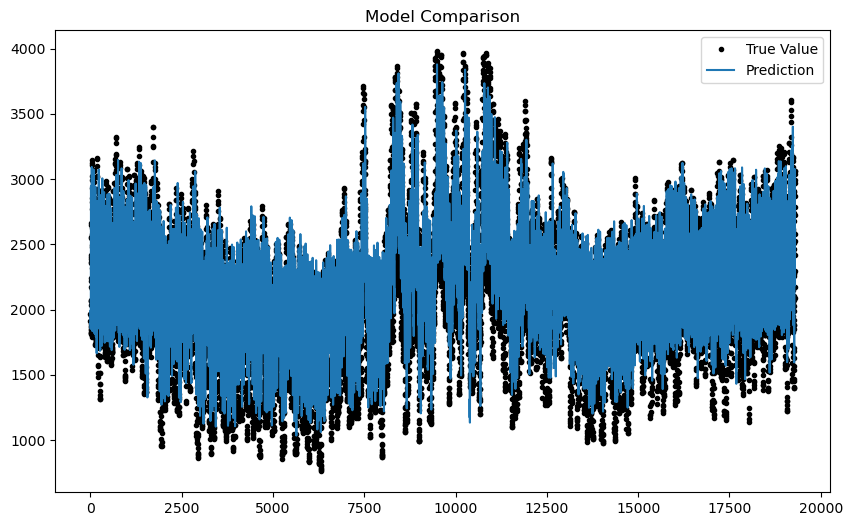

In [205]:
def comparison_plot():
    """Visualizing the training + validation sets"""
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.set_title("Model Comparison")
    ax.plot(new_ytest,'.k', label='True Value')
    ax.plot(new_yhat, label="Prediction")
    ax.legend()
    plt.show()   
comparison_plot()

In [206]:
# Forecasting

In [207]:
def split_seq_forecast(sequence, n_steps):
    X = list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + n_steps
    # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
    # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)        
    return array(X)

X_forecast= split_seq_forecast(forecast,96)
# summarize the data
print(X_forecast)

[[2020.326 1957.084 1925.654 1908.544 1892.61  1886.648 1893.758 1904.138
  1933.592 1978.984 2090.528 2229.43  2434.002 2603.34  2792.922 2774.648
  2584.242 2378.782 2162.768 1922.144 1758.102 1593.678 1489.082 1410.01
  1366.99  1326.118 1333.102 1365.13  1426.938 1493.86  1688.674 1791.844
  1915.828 2168.476 2418.626 2623.35  2774.14  2812.89  2794.87  2767.04
  2733.166 2689.046 2594.958 2484.748 2362.688 2237.79  2124.936 2040.502
  1966.784 1917.996 1865.222 1830.662 1825.026 1820.19  1828.932 1844.792
  1839.36  1850.866 1890.448 1930.612 2005.234 2083.59  2177.238 2249.852
  2345.294 2413.416 2462.55  2427.294 2404.658 2444.432 2537.234 2503.67
  2468.772 2586.878 2580.846 2566.512 2543.01  2450.15  2260.156 2260.386
  2412.44  2595.234 2731.356 2861.288 2921.72  2911.186 2882.886 2816.034
  2762.798 2738.742 2646.072 2544.382 2422.596 2308.776 2213.642 2134.49 ]]


In [208]:
# Forecast-

X_forecast = X_forecast.reshape((X_forecast.shape[0], X_forecast.shape[1], n_features))
yhat_1 = model.predict(X_forecast, verbose=0)
print(yhat_1)

[[2039.2484 1973.489  2006.6709 1949.4644 1897.8889 1903.655  1871.1819
  1927.7869 1963.609  1921.5092 2031.3971 1973.7424 2193.1787 2209.043
  2334.838  2457.0024 2338.7534 2352.4363 2309.0305 2160.0955 2179.4717
  2103.1191 2087.8093 1981.9014 2011.1545 2016.4979 2051.3716 2063.059
  2090.212  2101.1948 2153.2107 2175.3816 2311.9722 2462.329  2630.3667
  2742.8657 2886.7727 2872.7024 2789.9158 2686.6914 2730.6377 2683.073
  2557.2712 2489.685  2340.1274 2224.738  2088.5981 2037.7881]]


In [209]:
y_forecast=list(itertools.chain.from_iterable(yhat_1))
y_forecast

[2039.2484,
 1973.489,
 2006.6709,
 1949.4644,
 1897.8889,
 1903.655,
 1871.1819,
 1927.7869,
 1963.609,
 1921.5092,
 2031.3971,
 1973.7424,
 2193.1787,
 2209.043,
 2334.838,
 2457.0024,
 2338.7534,
 2352.4363,
 2309.0305,
 2160.0955,
 2179.4717,
 2103.1191,
 2087.8093,
 1981.9014,
 2011.1545,
 2016.4979,
 2051.3716,
 2063.059,
 2090.212,
 2101.1948,
 2153.2107,
 2175.3816,
 2311.9722,
 2462.329,
 2630.3667,
 2742.8657,
 2886.7727,
 2872.7024,
 2789.9158,
 2686.6914,
 2730.6377,
 2683.073,
 2557.2712,
 2489.685,
 2340.1274,
 2224.738,
 2088.5981,
 2037.7881]

In [210]:
y_true=uni_df[test_idx+96:]
y_true=list(y_true)
y_true

[2062.948,
 2001.888,
 1968.642,
 1931.752,
 1893.808,
 1878.102,
 1869.656,
 1858.488,
 1865.742,
 1871.21,
 1891.072,
 1928.148,
 2000.002,
 2066.176,
 2144.944,
 2161.158,
 2117.896,
 1998.534,
 1850.548,
 1622.73,
 1481.04,
 1344.14,
 1246.178,
 1232.908,
 1258.532,
 1275.14,
 1405.252,
 1440.176,
 1513.336,
 1615.28,
 1662.168,
 1763.936,
 1937.218,
 2181.036,
 2395.704,
 2605.384,
 2750.482,
 2784.968,
 2785.14,
 2751.862,
 2661.69,
 2525.924,
 2420.992,
 2321.674,
 2226.44,
 2115.17,
 2022.864,
 1940.888]

In [211]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true,y_forecast)

16.91624595670562

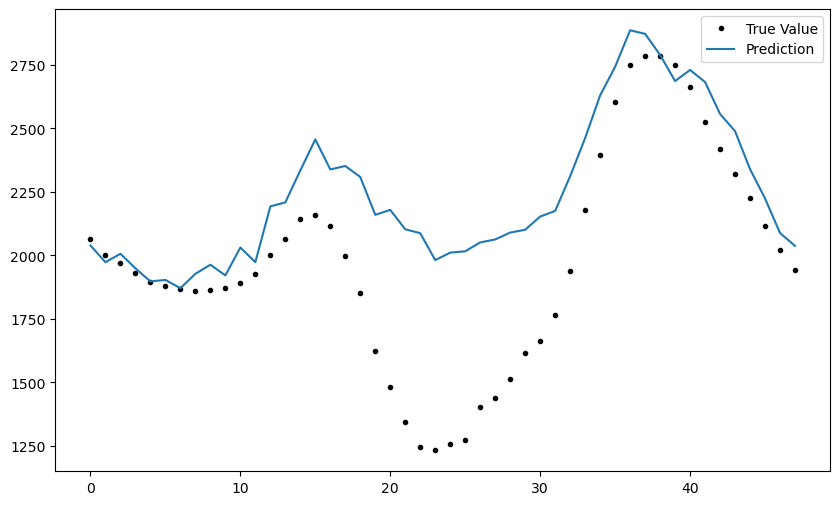

In [212]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(y_true,'.k', label='True Value')
ax.plot(y_forecast, label="Prediction")
ax.legend()
plt.show()